# Tutorial 5 - Data Imputation

**Course:** SYSC 4415 - Introduction to Machine Learning

**Semester:** Winter 2025

**Adapted by:** [Kevin Dick](https://kevindick.ai/), [Igor Bogdanov](igorbogdanov@cmail.carleton.ca) 

**Adapted From:** [Daniel Newman](https://github.com/dtnewman)'s [Notebook](https://nbviewer.jupyter.org/github/dtnewman/gradient_descent/blob/master/stochastic_gradient_descent.ipynb)

---

## Illustration of the Effect of Missing Data during Training and Testing

In this notebook, we will simulate the process of **filling in missing data with imputed values**. 

We will compare the performance of a classifier trained/tested on the datasets containing imputed values versus one where those rows are simply removed.

The general workflow is as follows:
1. Load the [Iris Dataset](https://raw.githubusercontent.com/jrgreen7/SYSC4906/master/orig-iris-data.csv)
2. Split data into train/test sets (50/50)
3. For i = 10:10:70%
    * **Impute Condition**
      - **Remove i%** of the training data from one feature
      - **Impute missing data** using **mean** of all data from that class
      - Train classifier
      - Test classifier
      - **Report score** along with i
    * **Removal Condition**
      - Remove training rows by replaving with NaN values,
      - Train Classifier
      - Test Classifier
      - **Report score** along with i


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import numpy as np
from sklearn.tree import DecisionTreeClassifier

# Load the dataset
url = 'https://raw.githubusercontent.com/jrgreen7/SYSC4906/master/F2019/orig-iris-data.csv'
iris_data = pd.read_csv(url)
# Note that iris = seaborn.load_dataset("iris") would also work (with diff column names)

# Quickly visualize first few rows
iris_data.head()

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


To simplify the experiment, we will only consider a single feature: `sepal_width_cm`

In [2]:
# Drop all features except petal_width_cm
iris_data.drop(['sepal_length_cm', 'petal_length_cm', 'petal_width_cm'], axis=1, inplace=True)
#
# Describe the data (gives range of each feature, etc)
iris_data.describe()

,sepal_width_cm
count,150.000000
mean,3.054000
std,0.433594
min,2.000000
25%,2.800000
50%,3.000000
75%,3.300000
max,4.400000


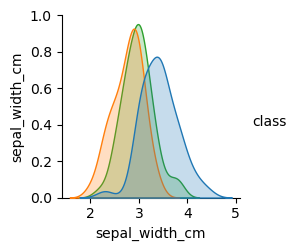

In [3]:
# Plot the features, in pairs
sb.pairplot(iris_data.dropna(), hue='class'); # Dropping NA values, but shouldn't be any yet...
plt.show()

### Avoid Data Leakage: Split the Dataset into Train and Test 

**Critical:** we MUST split the dataset before we impute the values!

**[Data Leakage](https://www.kaggle.com/alexisbcook/data-leakage)** occurs when information about the **test samples** are somehow **encoded** within the **training dataset**. This results in a biased, overfit, and non-generalizable method and inflates the performance.

In this case, the values from the test dataset should not be used for the imputation of missing values in the training dataset.

In [4]:
# Split the data (doing this in Pandas rather than using sklearn)

iris_data_copy = iris_data.copy()
train_set = iris_data_copy.sample(frac=0.5, random_state=0)
test_set = iris_data_copy.drop(train_set.index)

### Run the Experiment

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
# Vary the amount of missing feature values from 10% to 90%
for i in np.linspace(0.1, 0.9, num=9):
  # Randomly select some rows based on the current fraction
  missingRows = train_set.sample(frac=i, random_state=1)
  train_set_copy = train_set.copy()

  train_set_copy.describe()
    
  # Replace those selected rows with NaN --> 'simulated missing data'
  train_set_copy.loc[missingRows.index, 'sepal_width_cm'] = np.NaN; # Replace missing rows with NaN for sepal_width_cm feature

  # Remove the missing rows prior to computing the mean of the feature:
  train_set_copy_noNA = train_set_copy.dropna(inplace=False)

  # print(train_set_copy_noNA.describe())
        
  # Compute the average petal width, for each class (compute from non-NA rows)
  average_setosa = train_set_copy_noNA.loc[train_set_copy_noNA['class'] == 'Iris-setosa', 'sepal_width_cm'].mean()
  average_versicolor = train_set_copy_noNA.loc[train_set_copy_noNA['class'] == 'Iris-versicolor', 'sepal_width_cm'].mean()
  average_virginica = train_set_copy_noNA.loc[train_set_copy_noNA['class'] == 'Iris-virginica', 'sepal_width_cm'].mean()
  
  # Replace missing values with the mean value for that class
  train_set_copy.loc[(train_set_copy['class'] == 'Iris-setosa') &
              (train_set_copy['sepal_width_cm'].isnull()),
              'sepal_width_cm'] = average_setosa
  train_set_copy.loc[(train_set_copy['class'] == 'Iris-versicolor') &
              (train_set_copy['sepal_width_cm'].isnull()),
              'sepal_width_cm'] = average_versicolor
  train_set_copy.loc[(train_set_copy['class'] == 'Iris-virginica') &
              (train_set_copy['sepal_width_cm'].isnull()),
              'sepal_width_cm'] = average_virginica

  # Extract the data/classes from pandas into nparrays for the classifier:
  features_imp = train_set_copy['sepal_width_cm'].values.reshape(-1,1)
  labels_imp = train_set_copy['class'].values.reshape(-1,1)

  # CONDITION 1: With Imputation
  dt_classifier_imp = DecisionTreeClassifier()
  dt_classifier_imp.fit(features_imp, labels_imp)

  # Train a DT classifier without imputation
  features_drop = train_set_copy_noNA['sepal_width_cm'].values.reshape(-1,1)
  labels_drop = train_set_copy_noNA['class'].values.reshape(-1,1)

  # CONDITION 2: Without Imputation
  dt_classifier_drop = DecisionTreeClassifier()
  dt_classifier_drop.fit(features_drop, labels_drop)
  
  # Test the DT classifier with imputation
  test_features = test_set['sepal_width_cm'].values.reshape(-1,1)
  test_labels = test_set['class'].values 
  
  score_imp = dt_classifier_imp.score(test_features, test_labels)
  # Test the DT classifier without imputation (NaN rows removed)
  score_drop = dt_classifier_drop.score(test_features, test_labels)

  # Print the score:
  print(f'For {i*100:.0f}% missing data —\tAccuracy Imputed: {score_imp:.8f}\tAccuracy Dropped: {score_drop:.8f}\t diff: {score_imp-score_drop:.8f}')
    

For 10% missing data —	Accuracy Imputed: 0.49333333	Accuracy Dropped: 0.49333333	 diff: 0.00000000
For 20% missing data —	Accuracy Imputed: 0.45333333	Accuracy Dropped: 0.45333333	 diff: 0.00000000
For 30% missing data —	Accuracy Imputed: 0.46666667	Accuracy Dropped: 0.46666667	 diff: 0.00000000
For 40% missing data —	Accuracy Imputed: 0.49333333	Accuracy Dropped: 0.49333333	 diff: 0.00000000
For 50% missing data —	Accuracy Imputed: 0.54666667	Accuracy Dropped: 0.53333333	 diff: 0.01333333
For 60% missing data —	Accuracy Imputed: 0.60000000	Accuracy Dropped: 0.54666667	 diff: 0.05333333
For 70% missing data —	Accuracy Imputed: 0.49333333	Accuracy Dropped: 0.49333333	 diff: 0.00000000
For 80% missing data —	Accuracy Imputed: 0.53333333	Accuracy Dropped: 0.53333333	 diff: 0.00000000
For 90% missing data —	Accuracy Imputed: 0.52000000	Accuracy Dropped: 0.52000000	 diff: 0.00000000


### Discussion

**Questions:**
1.  What if feature data were missing from the test data? 
2.  How would you impute the missing feature values? 
3.  Would it have more or less of an effect than missing data during training?

## Take Away Messages
* Imputation is a method to fill in missnig values.
* **Data Leakage** occurs when information about the **test samples** is somehow **encoded** within the **training dataset**, resulting in possible overfitting and inflated model performance.
* Imputation vs. dropping samples generally leads to higher performance.
* Imputation in the test set should only be done if you have domain knowledge (e.g. an expert) or you know that you will obtain that value during deployment.

---

### (Optional) Open-Ended/Applied Homework
* Implement **your own/other** data imputation methods.
* **Compare performance** with mean-based imputation
* Does one perform **statistically significantly** better than simply dropping samples?
* What happens when you have **multiple features**?
* Can you impute the value of **one missing feature using other features**?
---

$\blacksquare$
